[Ссылка на контест Kaggle](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)

Задача: (регрессия) предсказание продаж товаров (в соответствующих товару единицах) в течение 15 дней по историческим данных о продажах.
Данные: исторические данные о продажах тоавров в сети супермаркетов в Эквадоре.

# Подключения

In [ ]:
!pip install optuna

In [ ]:
from datetime import timedelta
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, root_mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

from statsmodels.tsa.arima.model import ARIMA
import optuna

import yfinance as yf

# Загрузка данных

In [ ]:
data_root = '/content/drive/MyDrive/Colab Notebooks/data/StoreSales/'

In [ ]:
train_data = pd.read_csv(data_root + 'train.csv')
test_data = pd.read_csv(data_root + 'test.csv')

transactions = pd.read_csv(data_root + 'transactions.csv')
stores = pd.read_csv(data_root + 'stores.csv')

oil = pd.read_csv(data_root + 'oil.csv', parse_dates=['date'])
holidays_events = pd.read_csv(data_root + 'holidays_events.csv')

sample_submission = pd.read_csv(data_root + 'sample_submission.csv')

# Предобработка данных

В трейне хранятся данные о продажах товаров по категориям.
 - date - дата
 - store_nbr - номер точки продаж
 - family - категория товаров
 - sales - сумма продаж ($, целевая переменная)
 - onpromotion - кол-во продаж (штук или кг)

In [ ]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
train_data['date'] = pd.to_datetime(train_data['date'], format="%Y-%m-%d")

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [ ]:
train_data.isna().sum().sum()

0

In [ ]:
oil.isna().sum().sum()

43

In [ ]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


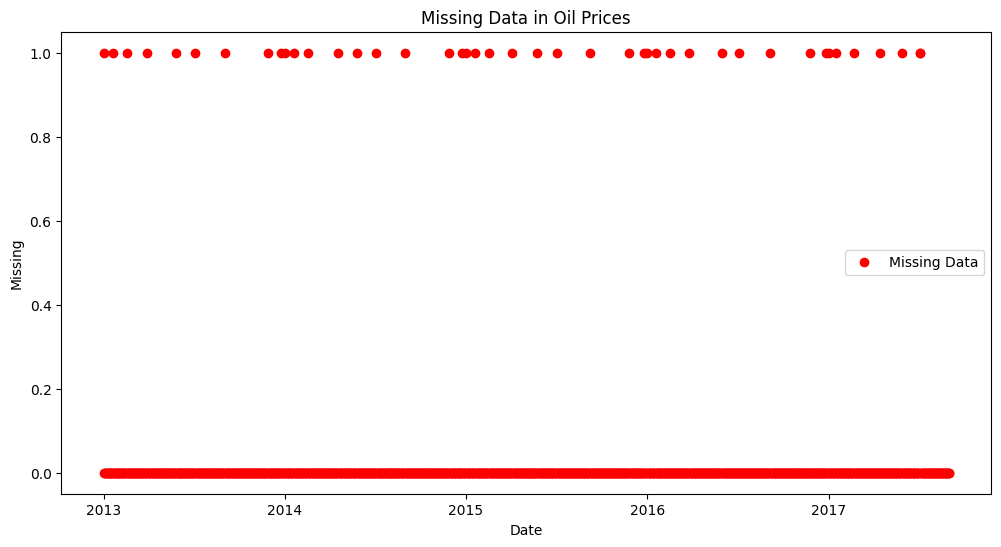

In [ ]:
oil.set_index('date', inplace=True)

missing = oil['dcoilwtico'].isnull()

plt.figure(figsize=(12, 6))
plt.plot(missing.index, missing, linestyle='', marker='o', color='red', label='Missing Data')
plt.title('Missing Data in Oil Prices')
plt.xlabel('Date')
plt.ylabel('Missing')
plt.legend()
plt.show()

oil.reset_index(inplace=True)

In [ ]:
min_date = oil['date'].min()
max_date = oil['date'].max()

start_date = min_date - timedelta(days=60)
end_date = max_date + timedelta(days=60)

oil_yf = yf.download('CL=F', start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), progress=True)

oil_yf = oil_yf[['Adj Close']].reset_index()
oil_yf.columns = ['date', 'dcoilwtico']
oil_yf.head()

[*********************100%***********************]  1 of 1 completed


,date,dcoilwtico
0,2012-11-02,84.860001
1,2012-11-05,85.650002
2,2012-11-06,88.709999
3,2012-11-07,84.440002
4,2012-11-08,85.089996


In [ ]:
full_oil = pd.merge(oil, oil_yf, on='date', how='outer').sort_values(by='date')
full_oil.drop(columns=['dcoilwtico_x'], inplace=True)
full_oil.columns = ['date', 'dcoilwtico']
full_oil['dcoilwtico'] = full_oil['dcoilwtico'].interpolate(method='linear')
full_oil.head()

,date,dcoilwtico
0,2012-11-02,84.860001
1,2012-11-05,85.650002
2,2012-11-06,88.709999
3,2012-11-07,84.440002
4,2012-11-08,85.089996


In [ ]:
full_oil.dcoilwtico.isna().sum()

0

In [ ]:
oil = full_oil

In [ ]:
oil.isna().sum().sum()

0

# Конструирование признаков

In [ ]:
train_data.shape

(3000888, 6)

In [ ]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
print(f"Кол-во категорий товаров: {len(train_data.family.unique())}")

Кол-во категорий товаров: 33


In [ ]:
print(f"В трейне данные за {len(train_data.date.unique())} дней")

В трейне данные за 1684 дней


<Axes: xlabel='date', ylabel='dcoilwtico'>

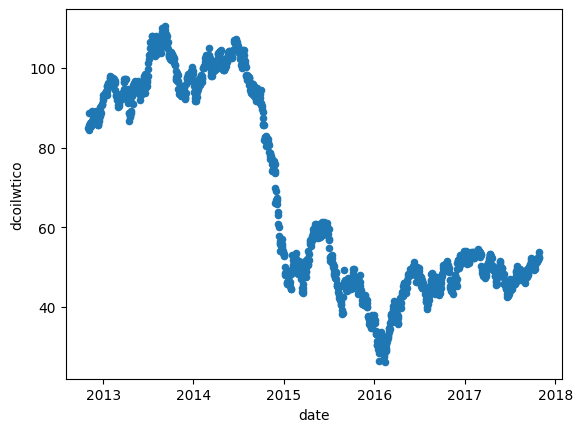

In [ ]:
oil.plot.scatter(x='date', y='dcoilwtico')

In [ ]:
def add_oil_prices(data, oil_data):
    """
    Добавляет данные о ценах на нефть и их лаговые значения в выборку.

    :param data: DataFrame, исходная выборка с колонкой 'date'.
    :param oil_data: DataFrame, данные о ценах на нефть с колонками 'date' и 'dcoilwtico'.
    :return: DataFrame с добавленными колонками 'oil_price', 'oil_price_lag_7' и 'oil_price_lag_30'.
    """
    oil_data = oil_data.rename(columns={'dcoilwtico': 'oil_price'})
    oil_data['date'] = pd.to_datetime(oil_data['date'])
    data['date'] = pd.to_datetime(data['date'])

    data = pd.merge(data, oil_data, on='date', how='left')

    data['oil_price'] = data['oil_price'].ffill()

    data['oil_price_lag_7'] = data['oil_price'].shift(7)
    data['oil_price_lag_30'] = data['oil_price'].shift(30)

    data['oil_price_lag_7'] = data['oil_price_lag_7'].bfill()
    data['oil_price_lag_30'] = data['oil_price_lag_30'].bfill()

    return data

In [ ]:
def add_store_features(data, stores_data):
    """
    Добавляет данные о магазинах в выборку.

    :param data: DataFrame, исходная выборка с колонкой 'store_nbr'.
    :param stores_data: DataFrame, данные о магазинах с колонками 'store_nbr', 'city', 'state', 'type', 'cluster'.
    :return: DataFrame с добавленными фичами из stores_data.
    """
    data = pd.merge(data, stores_data, on='store_nbr', how='left')
    return data

In [ ]:
def add_holiday_features(data, holidays_data):
    """
    Добавляет данные о праздниках в выборку, учитывая переносы.

    :param data: DataFrame, исходная выборка с колонкой 'date'.
    :param holidays_data: DataFrame, данные о праздниках с колонками 'date', 'type', 'description', 'transferred', и другими.
    :return: DataFrame с добавленными фичами о праздниках.
    """
    data['date'] = pd.to_datetime(data['date'])
    holidays_data['date'] = pd.to_datetime(holidays_data['date'])

    holidays_data['actual_holiday_date'] = holidays_data['date']

    transferred_holidays = holidays_data[holidays_data['transferred'] == 'Transfer']
    for _, row in transferred_holidays.iterrows():
        original_holiday = holidays_data[
            (holidays_data['description'] == row['description'].replace("Traslado ", "")) &
            (holidays_data['transferred'] == 'Holiday')
        ]
        if not original_holiday.empty:
            holidays_data.loc[holidays_data['date'] == row['date'], 'actual_holiday_date'] = original_holiday.iloc[0]['date']

    holidays_data = holidays_data[holidays_data['transferred'] != 'Transfer']

    holidays_data = holidays_data[['actual_holiday_date', 'locale', 'locale_name', 'description']].rename(
        columns={'actual_holiday_date': 'date'}
    )
    data = pd.merge(data, holidays_data, on='date', how='left')

    data['is_holiday'] = data['type'].notnull().astype(int)
    data['holiday_type'] = data['type'].fillna('None')
    data['holiday_description'] = data['description'].fillna('None')

    return data

In [ ]:
def fill_holiday_features(data):
    """
    Обрабатывает и исправляет значения в фичах, добавленных из данных о праздниках.
    Если дата не является праздничной (определяется по пропускам в колонке 'locale'),
    корректирует значения фич:
    - 'holiday_type' устанавливается в 'NO_HOLIDAY'
    - 'is_holiday' устанавливается в 0
    - Строковые фичи ('locale', 'locale_name', 'description', 'holiday_description') заполняются пустыми строками.

    :param data: DataFrame с колонками 'locale', 'locale_name', 'description',
                 'is_holiday', 'holiday_type', 'holiday_description'.
    :return: DataFrame с исправленными значениями.
    """
    non_holiday_condition = data['locale'].isna()

    data.loc[non_holiday_condition, 'locale'] = ''
    data.loc[non_holiday_condition, 'locale_name'] = ''
    data.loc[non_holiday_condition, 'description'] = ''
    data.loc[non_holiday_condition, 'holiday_description'] = ''
    data.loc[non_holiday_condition, 'holiday_type'] = 'NO_HOLIDAY'
    data.loc[non_holiday_condition, 'is_holiday'] = 0

    return data

In [ ]:
def encode_categorical_features(data, categorical_columns):
    """
    Кодирует указанные категориальные фичи с помощью OrdinalEncoder.

    :param data: DataFrame, исходная выборка с категориальными признаками.
    :param categorical_columns: Список строк, содержащий имена категориальных колонок, которые нужно закодировать.
    :return: DataFrame с закодированными категориальными признаками.
    """
    encoder = OrdinalEncoder()
    data[categorical_columns] = encoder.fit_transform(data[categorical_columns])
    return data

In [ ]:
categorical_columns=['family', 'city', 'state', 'type', 'locale', 'locale_name', 'holiday_type']

In [ ]:
def fullFE(data, categorical_columns):
  global oil, stores, holidays_events

  new_data = data.copy()

  new_data = add_oil_prices(new_data, oil)
  new_data = add_store_features(new_data, stores)
  new_data = add_holiday_features(new_data, holidays_events)
  new_data = fill_holiday_features(new_data)
  new_data = new_data.drop(columns=['description'])
  new_data = encode_categorical_features(new_data, categorical_columns=categorical_columns)

  return new_data

In [ ]:
Xy_train = fullFE(train_data, categorical_columns)

In [ ]:
X_test = fullFE(test_data, categorical_columns)

# Обучение

In [ ]:
def rmsle(y_true, y_pred):
    y_true = np.maximum(y_true, 0)
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def rmse(y_true, y_pred):
    y_true = np.maximum(y_true, 0)
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(root_mean_squared_error(y_true, y_pred))

In [ ]:
Xy_train = Xy_train.drop(columns=['holiday_description'])

In [ ]:
grouped = Xy_train.groupby(['store_nbr', 'family'])

train_rmsles = []
train_rmses = []

test_rmsles = []
test_rmses =[]

In [ ]:
for (store, family), group in tqdm(grouped):
    duplicates = group[group.duplicated(subset='date', keep=False)]

    if not duplicates.empty:
        print(f"Дублирующиеся строки для store_nbr={store}, family={family}:")
        print(duplicates)
        print("-" * 50)
    break

  0%|          | 0/1782 [00:00<?, ?it/s]

Дублирующиеся строки для store_nbr=1, family=0.0:
              id       date  store_nbr  family  sales  onpromotion  \
233442    233442 2013-05-12          1     0.0    1.0            0   
233443    233442 2013-05-12          1     0.0    1.0            0   
313632    311850 2013-06-25          1     0.0    2.0            0   
313633    311850 2013-06-25          1     0.0    2.0            0   
313634    311850 2013-06-25          1     0.0    2.0            0   
331452    326106 2013-07-03          1     0.0    1.0            0   
331453    326106 2013-07-03          1     0.0    1.0            0   
639738    632610 2013-12-22          1     0.0    0.0            0   
639739    632610 2013-12-22          1     0.0    0.0            0   
969408    960498 2014-06-25          1     0.0    1.0            0   
969409    960498 2014-06-25          1     0.0    1.0            0   
969410    960498 2014-06-25          1     0.0    1.0            0   
969411    960498 2014-06-25          1  

Дубликаты возникли из-за разных локальных праздников в разных местах в один день. Пока просто возьмём первое значение

In [ ]:
for (store, family), group in tqdm(grouped):
    group = group.drop_duplicates(subset='date', keep='first') # пока просто удалим дублирующие строки

    group = group.set_index('date').asfreq('D')
    group['sales'] = group['sales'].astype(float).fillna(0)
    sales = group['sales']

    train, test = train_test_split(sales, test_size=0.2, shuffle=False)

    model = ARIMA(train, order=(1, 0, 0))
    model_fit = model.fit()

    train_pred = model_fit.predict(start=train.index[0], end=train.index[-1])
    train_rmsle = rmsle(train, train_pred)
    train_rmse = rmse(train, train_pred)
    train_rmsles.append(train_rmsle)
    train_rmses.append(train_rmse)

    test_pred = model_fit.predict(start=test.index[0], end=test.index[-1])
    test_rmsle = rmsle(test, test_pred)
    test_rmse = rmse(test, test_pred)
    test_rmsles.append(test_rmsle)
    test_rmses.append(test_rmse)

 24%|██▍       | 429/1782 [01:37<03:27,  6.53it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████| 1782/1782 [05:54<00:00,  5.03it/s]


In [ ]:
mean_train_rmsle = np.mean(train_rmsles)
mean_train_rmse = np.mean(train_rmses)

mean_test_rmsle = np.mean(test_rmsles)
mean_test_rmse = np.mean(test_rmses)

print(f"Mean RMSLE for train: {mean_train_rmsle:.5f}")
print(f"Mean RMSE for train: {mean_train_rmse:.5f}")

print(f"Mean RMSLE for test: {mean_test_rmsle:.5f}")
print(f"Mean RMSE for test: {mean_test_rmse:.5f}")

Mean RMSLE for train: 0.84343
Mean RMSE for train: 7.28777
Mean RMSLE for test: 0.77576
Mean RMSE for test: 9.74058


# Предикт

In [ ]:
predictions = sample_submission.copy()

grouped_train = Xy_train.groupby(['store_nbr', 'family'])
grouped_test = X_test.groupby(['store_nbr', 'family'])

for (store, family), train_group in tqdm(grouped_train):
    train_group = train_group.drop_duplicates(subset='date', keep='first')
    train_group = train_group.set_index('date').asfreq('D')
    train_group['sales'] = train_group['sales'].astype(float).fillna(0)

    if (store, family) in grouped_test.groups:
        test_group = grouped_test.get_group((store, family))
        test_group = test_group.set_index('date').asfreq('D')
        test_index = test_group.index

        sales = train_group['sales']
        model = ARIMA(sales, order=(0, 0, 2))
        model_fit = model.fit()

        forecast = model_fit.predict(start=test_index[0], end=test_index[-1])

        test_ids = test_group['id']
        predictions.loc[predictions['id'].isin(test_ids), 'sales'] = forecast.values

 37%|███▋      | 658/1782 [09:11<21:40,  1.16s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
100%|██████████| 1782/1782 [25:51<00:00,  1.15it/s]


In [ ]:
predictions.shape

(28512, 2)

In [ ]:
predictions.to_csv('predictions.csv', index=False)

Score:

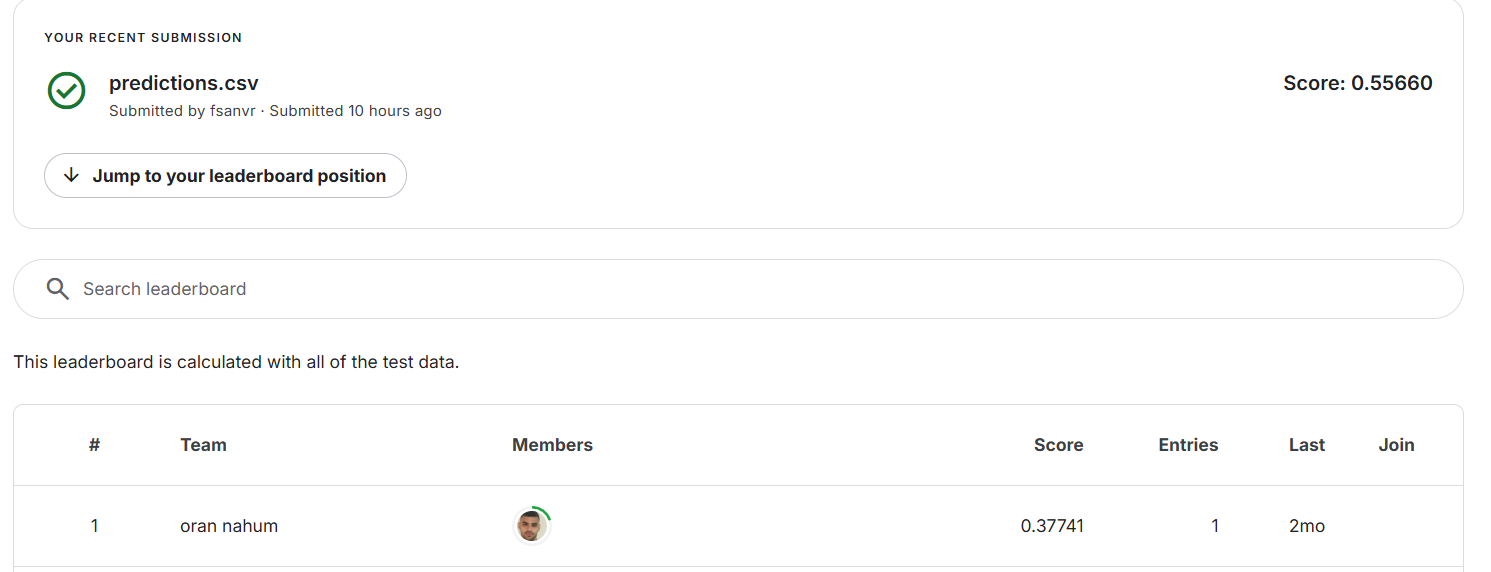